In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
])

# Load the CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Iterate through the training dataset
for images, labels in train_loader:
    # Process your images and labels here
    pass

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

def add_gaussian_noise(image, noise_sigma=0.1):
    """Add Gaussian noise to an image tensor."""
    noisy_image = image + noise_sigma * torch.randn_like(image)
    return torch.clip(noisy_image, 0, 1)

class NoisyCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, noise_sigma=0.1):
        super(NoisyCIFAR10, self).__init__(root=root, train=train, download=download, transform=transform)
        self.noise_sigma = noise_sigma

    def __getitem__(self, index):
        image, label = super(NoisyCIFAR10, self).__getitem__(index)

        # Add Gaussian noise to the image
        noisy_image = add_gaussian_noise(image, self.noise_sigma)

        return noisy_image, label

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the noisy CIFAR-10 training dataset
train_dataset = NoisyCIFAR10(root='./data', train=True, download=True, transform=transform, noise_sigma=0.1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the noisy CIFAR-10 test dataset
test_dataset = NoisyCIFAR10(root='./data', train=False, download=True, transform=transform, noise_sigma=0.1)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Iterate through the training dataset
for images, labels in train_loader:
    # Process your images and labels here
    pass


Epoch 1/10, Loss: 0.002048932947218418
Epoch 2/10, Loss: 0.0019393607508391142
Epoch 3/10, Loss: 0.0017872046446427703
Epoch 4/10, Loss: 0.001604835269972682
Epoch 5/10, Loss: 0.0017350426642224193
Epoch 6/10, Loss: 0.0015524658374488354
Epoch 7/10, Loss: 0.0018014051020145416
Epoch 8/10, Loss: 0.0017223283648490906
Epoch 9/10, Loss: 0.001624686410650611
Epoch 10/10, Loss: 0.0016992974560707808


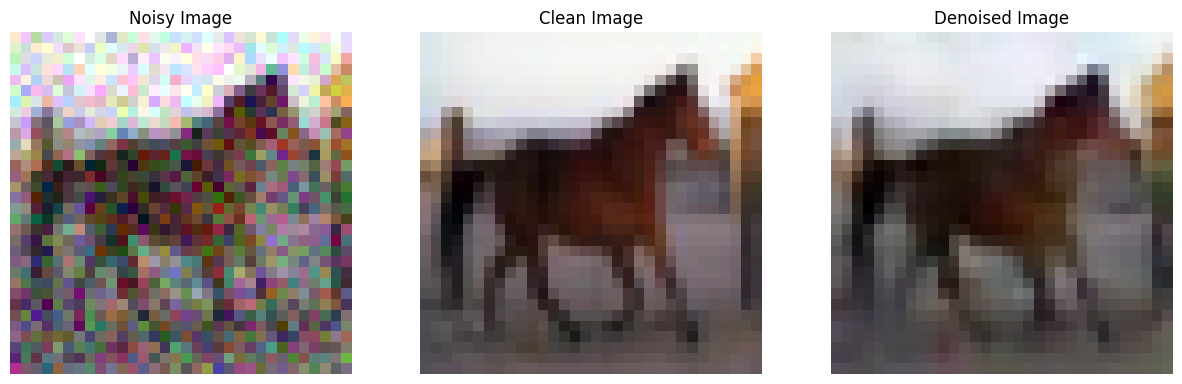

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

def add_gaussian_noise(image, noise_sigma=0.1):
    """Add Gaussian noise to an image tensor."""
    noisy_image = image + noise_sigma * torch.randn_like(image)
    return torch.clip(noisy_image, 0, 1)

class NoisyCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, noise_sigma=0.1):
        super(NoisyCIFAR10, self).__init__(root=root, train=train, download=download, transform=transform)
        self.noise_sigma = noise_sigma

    def __getitem__(self, index):
        image, label = super(NoisyCIFAR10, self).__getitem__(index)

        # Add Gaussian noise to the image
        noisy_image = add_gaussian_noise(image, self.noise_sigma)

        return noisy_image, image  # Return both noisy and clean images

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training function
def train_score_network(model, dataloader, epochs=200, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for noisy_image, clean_image in dataloader:
            noisy_image, clean_image = noisy_image.cuda(), clean_image.cuda()
            optimizer.zero_grad()
            output = model(noisy_image)

            # Resize the output to match the input dimensions
            output = F.interpolate(output, size=clean_image.shape[2:])

            loss = criterion(output, clean_image)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
import matplotlib.pyplot as plt
import torch

def plot_images(images, titles, cols=3):
    num_images = len(images)
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
    plt.figure(figsize=(15, 5 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        # Remove the batch dimension, move to CPU, and detach from the computation graph
        image_to_plot = image.squeeze().cpu().detach()
        # Normalize the image to the range [0, 1]
        image_to_plot = (image_to_plot - image_to_plot.min()) / (image_to_plot.max() - image_to_plot.min())
        # Ensure the image has three dimensions (height, width, channels)
        if image_to_plot.dim() == 3:
            image_to_plot = image_to_plot.permute(1, 2, 0)
        plt.imshow(image_to_plot.numpy())
        plt.title(title)
        plt.axis('off')
    plt.show()

# Denoising function
def denoise_image(noisy_image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        noisy_image = noisy_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        denoised_image = model(noisy_image)
        denoised_image = F.interpolate(denoised_image, size=noisy_image.shape[2:])
    return denoised_image.cpu()

# Example usage
if __name__ == "__main__":
    # Load the noisy CIFAR-10 training dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = NoisyCIFAR10(root='./data', train=True, download=True, transform=transform, noise_sigma=0.1)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize the score network
    model = UNet().cuda()

    # Train the score network
    train_score_network(model, train_loader, epochs=10)

    # Load a noisy image for denoising
    noisy_image, clean_image = next(iter(train_loader))
    noisy_image = noisy_image[0].unsqueeze(0)  # Take the first image in the batch

    # Denoise the image
    denoised_image = denoise_image(noisy_image, model)

    # Plot the images
    plot_images([noisy_image.cpu(), clean_image[0].cpu(), denoised_image.cpu()], ["Noisy Image", "Clean Image", "Denoised Image"])
